In [1]:
import os
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib

import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score

import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    max_n_mix:         Maximum number of componds in XRD mix
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  n_mix=[1,2,3], resonable_mixing=False, min_mixing_ratio=0.05, 
                  high_orientation_probability=0.2, crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.choice(n_mix, batch_size, replace=True)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing:
                self.sample_idxs = []
                samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                self.n_mix_list[i] = min(self.n_mix_list[i],len(samples))
                samples = np.random.choice(samples, self.n_mix_list[i], replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                if np.random.binomial(1, high_orientation_probability) == 1:
                    high_orientation_peak_index = np.random.choice(np.argpartition(dataloader.X_short,-3)[-3:],1)[0]
                    self.X_short = np.array([self.X_short[high_orientation_peak_index]])
                    self.twotheta_short = np.array([self.twotheta_short[high_orientation_peak_index]])
                
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])
                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list, self.n_mix_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [3]:
folder = os.getcwd()
cif_folder = os.path.join(folder, 'cif')

dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

Text(0, 0.5, 'Normalized intensity')

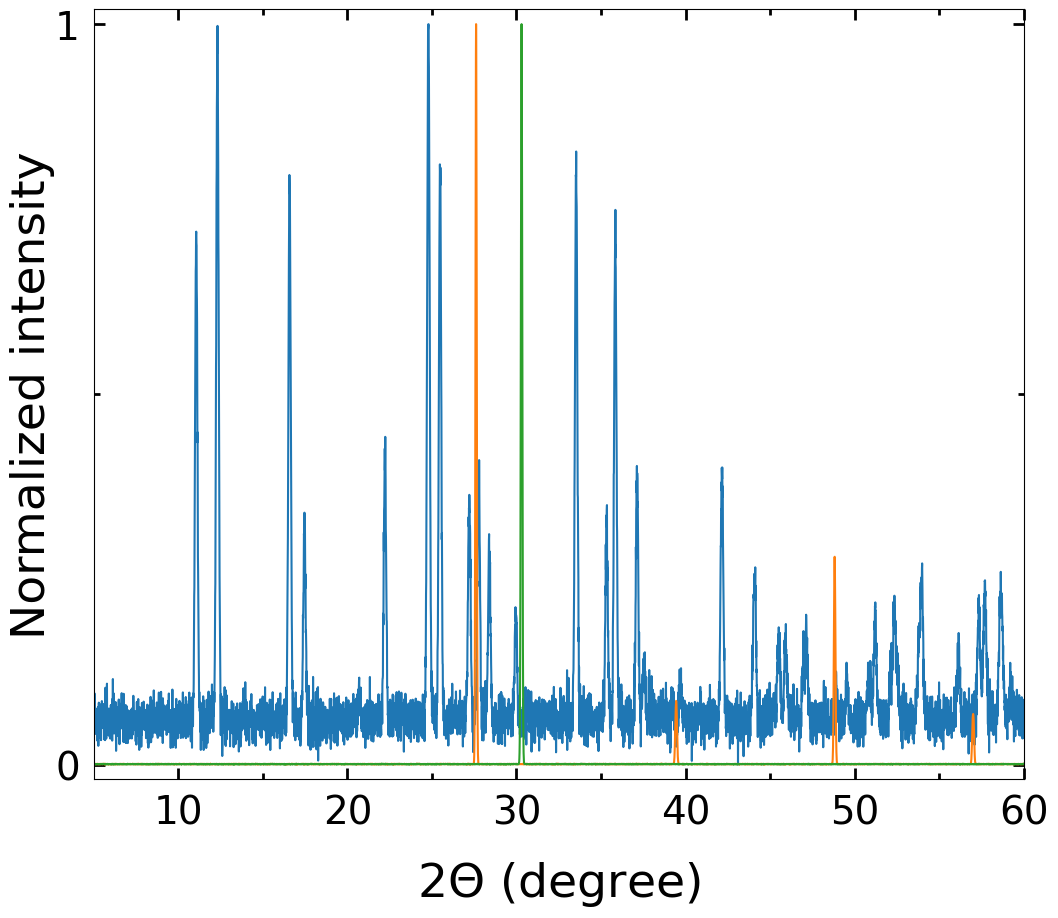

In [4]:
Xs, Ys, element_list, formula_list, n_mix_list = dataloader.load_data(batch_size=3, n_mix=[1], resonable_mixing=True,
                                                          high_orientation_probability=0.3, noise_sigma_list=np.logspace(-4,-1,num=101))
fig, ax = plt.subplots(figsize=(12, 10))

for i in range(len(element_list)):
    ax.plot(np.arange(5.00, 60.01, 0.01), Xs[i])
    
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=1, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    
ax.axes.set_xlim([5,60])
ax.axes.set_ylim([-0.02,1.02])

ax.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
ax.set_ylabel(r'Normalized intensity', labelpad=0, fontsize=34)

# 2.1 Single-phase

In [ ]:
visual_embedding_dim = 50
configuration = VisualBertConfig(vocab_size=len(tokenizer), visual_embedding_dim=visual_embedding_dim, hidden_size=int(Xs.shape[1]/visual_embedding_dim), 
                                 num_attention_heads=1, num_labels=Ys.shape[1])
print(configuration)
model = VisualBertForQuestionAnswering(configuration).to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-4)

train_losses,train_y_true,train_y_pred = [],[],[]

In [ ]:
n_mix = [1]
batch_size = 50
prompt_type_list = ['full']
organic_list = ['FA','MA']
save_training_results = False

model_folder = r'Single phase'
model.train()

sample_size_list = [1e2,3e2,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6,1e7]

for i in range(int(sample_size_list[-1]/batch_size)):
    Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=batch_size, n_mix=n_mix,
                                                              high_orientation_probability=0.2, crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.01, 1))
    Xs = Xs[:,:-1,:].reshape((Xs.shape[0],int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    X_prompts = []
    for j in range(batch_size):
        random.shuffle(element_list[j])
        prompt_type = np.random.choice(prompt_type_list)
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[j] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[j]))

    visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            
    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(Ys)).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), labels=labels.to('cuda'))
    logits = outputs.logits
    loss = outputs.loss
    
    current_sample_size = int((i+1)*batch_size)
    
    if current_sample_size == int(1e4):
        optimizer = AdamW(model.parameters(), lr=1e-5)
    elif current_sample_size == int(1e6):
        optimizer = AdamW(model.parameters(), lr=1e-6)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    y_true = np.array(labels)
    y_pred = np.array(logits.detach().cpu())
    if save_training_results:
        train_y_true.append(y_true)
        train_y_pred.append(y_pred)
    
    if (i+1)%10 == 0:
        print('{}\t{:.5f}\t{}'.format(i+1, np.array(loss.detach().cpu()), y_true.argmax(-1)[:15]-y_pred.argmax(-1)[:15]))
    train_losses.append(np.array(loss.detach().cpu()))
    
    if current_sample_size in sample_size_list:
        model.save_pretrained(os.path.join(folder, 'models', model_folder, '{}'.format(current_sample_size)), from_pt=True) 
        np.savetxt(os.path.join(folder, 'models', model_folder, 'train_loss.csv'), train_losses, delimiter=',')
        print('Save model for data size: {}'.format(current_sample_size))
        if save_training_results:
            with open(os.path.join(folder, 'models', model_folder, 'train_result.npy'), 'wb') as handle:
                joblib.dump({'y_true':train_y_true, 'y_pred':train_y_pred, 'loss':train_losses}, handle)

# 2.2 Multi-phase train

In [ ]:
visual_embedding_dim = 50
n_mix = [1,2,3]
configuration = VisualBertConfig(vocab_size=len(tokenizer), visual_embedding_dim=visual_embedding_dim, hidden_size=int(Xs.shape[1]/visual_embedding_dim), 
                                 num_attention_heads=1, num_labels=Ys.shape[1]+len(n_mix))
print(configuration)
model = VisualBertForQuestionAnswering(configuration).to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-4)

train_losses,train_y_true,train_y_pred = [],[],[]

In [ ]:
batch_size = 20
prompt_type_list = [None,'eds','full']
organic_list = ['FA','MA']
save_training_results = False

model_folder = r'20241022 random phase orientation full prompt 50 1e-4 lr n_weight'
n_phase = len(dataloader.sample_list)
model.train()

sample_size_list = [1e2,3e2,1e3,3e3,1e4,3e4,1e5,3e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,1.5e7,2e7,2.5e7,3e7]

for i in range(int(sample_size_list[-1]/batch_size)):
    Xs, Ys, element_list, formula_list, n_mix_list = dataloader.load_data(batch_size=batch_size, n_mix=n_mix,
                                                              high_orientation_probability=0.2, crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.01, 1))
    Xs = Xs[:,:-1,:].reshape((Xs.shape[0],int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    n_mix_list_onehot = np.zeros((n_mix_list.size, len(n_mix)))
    n_mix_list_onehot[np.arange(n_mix_list.size), n_mix_list-np.min(n_mix)] = 1
    Ys = np.concatenate((Ys,n_mix_list_onehot),axis=1)
    
    X_prompts = []
    for j in range(batch_size):
        random.shuffle(element_list[j])
        prompt_type = np.random.choice(prompt_type_list)
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[j] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[j]))

    visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            
    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(Ys)).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), labels=labels.to('cuda'))
    logits = outputs.logits
    if len(n_mix) > 1:
        weight = np.array(Ys)
        weight[:,-len(n_mix):] = weight[:,-len(n_mix):]*(len(n_mix)-1)*5
        weight[:,-len(n_mix):][weight[:,-len(n_mix):]==0] = 1/(len(n_mix)-1)*5
        phase_weight = n_phase/n_mix_list
        phase_weight = np.repeat(np.expand_dims(phase_weight,axis=1),n_phase,1)
        for j in range(batch_size):
            weight[j,:-len(n_mix)][weight[j,:-len(n_mix)]==1] = (n_phase-n_mix_list[j])/n_mix_list[j]
            weight[j,:-len(n_mix)][weight[j,:-len(n_mix)]==0] = (n_phase-n_mix_list[j])/n_phase
        loss = torch.nn.BCEWithLogitsLoss(weight=torch.from_numpy(weight).to(dtype=torch.float32).to('cuda'))(logits, labels.to('cuda'))
    else:
        loss = outputs.loss
    
    current_sample_size = int((i+1)*batch_size)
#     if current_sample_size == int(1e4):
#         optimizer = AdamW(model.parameters(), lr=3e-5)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    y_true = np.array(labels)
    y_pred = np.array(logits.detach().cpu())
    if save_training_results:
        train_y_true.append(y_true)
        train_y_pred.append(y_pred)
    
    if (i+1)%20 == 0:
        simp_labels, simp_logits = [], []
        results = []
        for j in range(batch_size):
            simp_labels.append(list(np.array(labels[j].nonzero().view(-1))))
            simp_logits.append(list(np.array(torch.topk(outputs.logits[j], len(simp_labels[-1])).indices.detach().cpu())))
            if set(simp_labels[-1]) == set(simp_logits[-1]):
                results.append(0)
            else:
                results.append(1)
        print('{}\t{:.5f}\t{}'.format(i+1, np.array(loss.detach().cpu()), results))
        
    train_losses.append(np.array(loss.detach().cpu()))
    
    if current_sample_size in sample_size_list:
        model.save_pretrained(os.path.join(folder, 'models', model_folder, '{}'.format(current_sample_size)), from_pt=True) 
        np.savetxt(os.path.join(folder, 'models', model_folder, 'train_loss.csv'), train_losses, delimiter=',')
        print('Save model for data size: {}'.format(current_sample_size))
        if save_training_results:
            with open(os.path.join(folder, 'models', model_folder, 'train_result.npy'), 'wb') as handle:
                joblib.dump({'y_true':train_y_true, 'y_pred':train_y_pred, 'loss':train_losses}, handle)